In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
max_epoch = 15
batch_size = 64
img_size = (128, 128)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)
vs_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_directory(r"C:\Users\Metehan Sevgil\Desktop\KODLAR\Anaconda\Bitirme\dataset\train",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

test_gen = ts_gen.flow_from_directory(r"C:\Users\Metehan Sevgil\Desktop\KODLAR\Anaconda\Bitirme\dataset\test",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

val_gen = vs_gen.flow_from_directory(r"C:\Users\Metehan Sevgil\Desktop\KODLAR\Anaconda\Bitirme\dataset\val",
                                        target_size=img_size, batch_size=batch_size, color_mode= 'rgb', class_mode='categorical')

Found 15000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [3]:
model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']   

| Block     | Dense Block Adı                  | Unit (Concat) Sayısı     |
| --------- | -------------------------------- | ------------------------ |
| **Conv1** | `conv1`                          | - (sadece 1 Conv katman) |
| **Conv2** | `conv2_block1` → `conv2_block6`  | 6                        |
| **Conv3** | `conv3_block1` → `conv3_block12` | 12                       |
| **Conv4** | `conv4_block1` → `conv4_block24` | 24                       |
| **Conv5** | `conv5_block1` → `conv5_block16` | 16                       |

In [4]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

total_layers = len(base_model.layers)
cut_point = total_layers // 3
print(f"Toplam katman sayısı: {total_layers}, İlk 1/3: {cut_point}")

Toplam katman sayısı: 427, İlk 1/3: 142


In [5]:
intermediate_layer = base_model.get_layer('conv3_block12_concat')
x = intermediate_layer.output

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)

output = Dense(5, activation='softmax')(x)  

lighter_model = Model(inputs=base_model.input, outputs=output)

lighter_model.compile(optimizer=SGD(), 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

lighter_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 134, 134, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                              

In [6]:
model_checkpoint = ModelCheckpoint('lighter_densenet121_model_128.h5', save_best_only=True, save_weights_only=False, monitor='val_loss')

In [7]:
history_lighter_densenet_128 = lighter_model.fit(train_gen,
                                    validation_data=val_gen,
                                    epochs=max_epoch,
                                    callbacks=[model_checkpoint])

Epoch 1/15
235/235 [==============================] - 95s 353ms/step - loss: 0.1724 - accuracy: 0.9367 - val_loss: 1.1297 - val_accuracy: 0.4272
Epoch 2/15
235/235 [==============================] - 68s 291ms/step - loss: 0.0746 - accuracy: 0.9723 - val_loss: 0.2083 - val_accuracy: 0.9260
Epoch 3/15
235/235 [==============================] - 74s 313ms/step - loss: 0.0547 - accuracy: 0.9805 - val_loss: 0.0583 - val_accuracy: 0.9760
Epoch 4/15
235/235 [==============================] - 73s 308ms/step - loss: 0.0382 - accuracy: 0.9869 - val_loss: 0.0297 - val_accuracy: 0.9890
Epoch 5/15
235/235 [==============================] - 70s 298ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0188 - val_accuracy: 0.9942
Epoch 6/15
235/235 [==============================] - 71s 300ms/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.0278 - val_accuracy: 0.9892
Epoch 7/15
235/235 [==============================] - 69s 294ms/step - loss: 0.0195 - accuracy: 0.9937 - val_loss: 0.0138 - val_ac

In [8]:
import json

with open("history_lighter_densenet_128.json", "w") as f:
    json.dump(history_lighter_densenet_128.history, f)

In [18]:
test_loss, test_acc = lighter_model.evaluate(test_gen)
print(f"\nModelin Test Seti Üzerindeki Performansı:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

79/79 [==============================] - 16s 195ms/step - loss: 0.0059 - accuracy: 0.9986

Modelin Test Seti Üzerindeki Performansı:
Test Accuracy: 0.9986
Test Loss: 0.0059


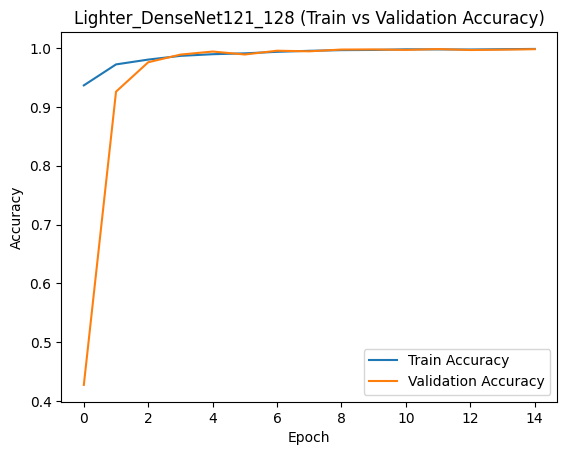

In [10]:
import matplotlib.pyplot as plt

plt.plot(history_lighter_densenet_128.history["accuracy"], label="Train Accuracy")
plt.plot(history_lighter_densenet_128.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Lighter_DenseNet121_128 (Train vs Validation Accuracy)")
plt.show()

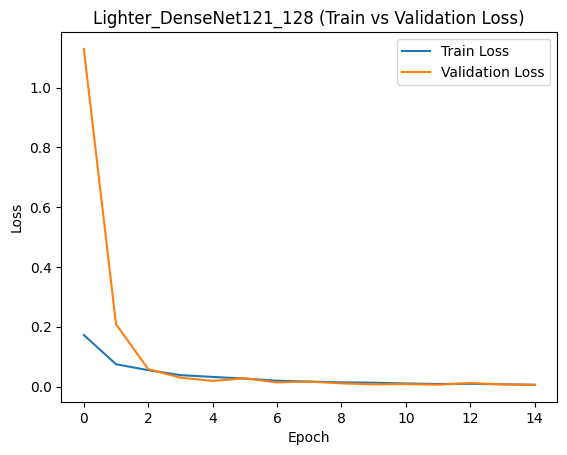

In [11]:
plt.plot(history_lighter_densenet_128.history["loss"], label="Train Loss")
plt.plot(history_lighter_densenet_128.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Lighter_DenseNet121_128 (Train vs Validation Loss)")
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
y_true = []
y_pred_probs = []

for i in range(len(test_gen)):
    img_batch, label_batch = next(test_gen)
    y_true.extend(np.argmax(label_batch, axis=1)) 
    preds = lighter_model.predict(img_batch)  
    y_pred_probs.extend(preds)

1/1 [==============================] - 1s 535ms/step


In [15]:
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred = np.argmax(y_pred_probs, axis=1)

In [16]:
report = classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys(), digits=4)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   colon_aca     1.0000    1.0000    1.0000      1000
     colon_n     1.0000    1.0000    1.0000      1000
    lung_aca     0.9980    0.9950    0.9965      1000
      lung_n     1.0000    1.0000    1.0000      1000
    lung_scc     0.9950    0.9980    0.9965      1000

    accuracy                         0.9986      5000
   macro avg     0.9986    0.9986    0.9986      5000
weighted avg     0.9986    0.9986    0.9986      5000



In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision:.4f}")

recall = recall_score(y_true, y_pred, average="weighted")
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_true, y_pred, average="weighted")
print(f"F1-score: {f1:.4f}")

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.9986
Recall: 0.9986
F1-score: 0.9986
Accuracy: 0.9986


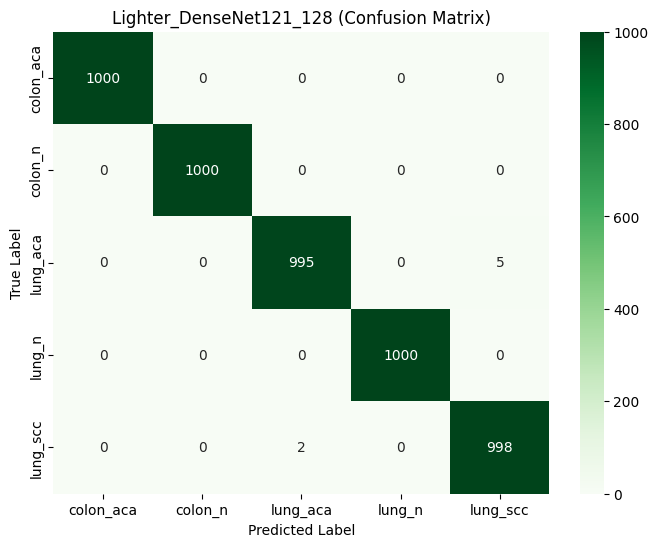

In [19]:
import seaborn as sns

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Lighter_DenseNet121_128 (Confusion Matrix)")
plt.show()

UNUTMA!!!

Conv katmanları azaltıldığında, öznitelik çıkarımı da zayıflar. Bu durum, modelin Dense katmanına gönderdiği tensör boyutunu ciddi şekilde etkiler ve parametre sayısının beklenenden fazla artmasına neden olur.

- Asıl modelde 4, 4, 1024 ile dense katmanında 4, 4, 1024 * 512 = 8.389.120   parametre elde edilirken,
- Bu modelimizde 16, 16, 512 ile bu modelde 16, 16, 512 * 512 = 67.108.864 parametre elde ediliyordu ve model daha ağır bir hale geliyordu. 
- Bu yüzden bu son modelde Flatten katmanı yerine GlobalAveragePooling2D kullanıldı ve 67.108.864 parametre yerine 1,581,125 parametre kullanıldı.
